# Who Gets Vaccinated? Machine Learning Predictions of H1N1 and Seasonal Flu Vaccine Uptake





## 1. Business Understanding
The goal of this project is to develop a machine learning model that can predict the likelihood that an individual received the 2009 H1N1 vaccine and the seasonal flu vaccine based on survey responses. These predictions are to be returned as probabilities, not binary classifications. This makes the problem a multi-label probabilistic classification task — with two separate target variables to predict.

By accurately predicting vaccine uptake probabilities, public health stakeholders can better understand the factors influencing vaccine behavior and potentially design targeted interventions to increase vaccination rates among underrepresented or hesitant populations.

A successful model will help:

1. Predict and profile vaccine-hesitant populations.

2. Guide more effective public health messaging.

3. Assist in real-time policy decisions during future outbreaks (e.g., COVID-19, RSV, Monkeypox).

4. Serve as a foundation for equity-based healthcare interventions.




###  Stakeholders: 
The primary stakeholders for this model include:

1. Public health officials and policymakers, such as those working in the CDC or WHO, who need to identify populations at higher risk of remaining unvaccinated.

2. Healthcare providers and outreach programs, who can use this information to target specific groups (e.g., those with low health literacy or without insurance).

3. Researchers in epidemiology and behavioral science, who seek to understand the behavioral and socio-demographic factors influencing vaccine hesitancy.




### Business Goals
Maximize prediction accuracy of vaccine uptake for both H1N1 and seasonal flu vaccines.

Identify key behavioral, attitudinal, and demographic drivers of vaccine behavior.

Inform public health strategy by pinpointing populations less likely to receive vaccines.

Enable resource prioritization, such as focused education or mobile clinics in high-risk groups.

### Key Questions
1. What individual-level characteristics (e.g., age, health status, beliefs, behavior) predict whether someone received the H1N1 or seasonal flu vaccine?

2. Are there groups with disproportionately low vaccine uptake?

3. How do recommendations from healthcare professionals influence vaccine behavior?

4. Can this model help anticipate future vaccine hesitancy for other campaigns?



# 2. Data understanding

Dataset Overview
The data originates from the National 2009 H1N1 Flu Survey, conducted in the United States to understand vaccine behaviors during the H1N1 pandemic. The full dataset includes respondent-level survey responses, capturing demographics, health status, behavioral practices, opinions about vaccines, and employment information.
Source: 2009 National H1N1 Flu Survey (N = ~26,000)

### Vaccine Dataset

| File Name               | Description                                          |
|-------------------------|------------------------------------------------------|
| training_set_features.csv | Input features (n ≈ 26,000 respondents)            |
| training_set_labels.csv   | Target labels for H1N1 and seasonal flu vaccine uptake |
| test_set_features.csv     | Features for test set                              |



### Target Variables
The task is to predict two independent binary variables:

Target Variable	Description
|Target Variable               | Description                                          |
|-------------------------|------------------------------------------------------|
| H1N1_vaccine	1 | received H1N1 vaccine           |
| H1N1 vaccine; 0    | Did not receive |
| Seasonal_vaccine	1     | Received H1N1 vaccine|
|  Seasonal flu vaccine; 0 | Did not receive |


These are modeled separately as a multi-label problem. Some individuals received both vaccines, others only one, and many received neither.

# 3. Data preparation and cleaning

In [150]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")


In [104]:
# Load the dataset
train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv("training_set_labels.csv")
test_features = pd.read_csv("test_set_features.csv")


In [105]:
# Initial exploration
print(train_features.shape)
print(train_labels.shape)

# Display the first few rows of the dataset
print(train_features.head())
print(train_labels.head())

print(train_features.info())



(26707, 36)
(26707, 3)
   respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                     

In [106]:
# Check for missing values
train_features.isnull().sum().sort_values(ascending=False).head(10)

employment_occupation    13470
employment_industry      13330
health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

In [107]:
# Merge labels
data = train_features.merge(train_labels, on="respondent_id")

# check merged data
print(data.info())

#drop respondent_id
data = data.drop(columns=['respondent_id'])

# Check for missing values
data.isnull().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

employment_occupation    13470
employment_industry      13330
health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

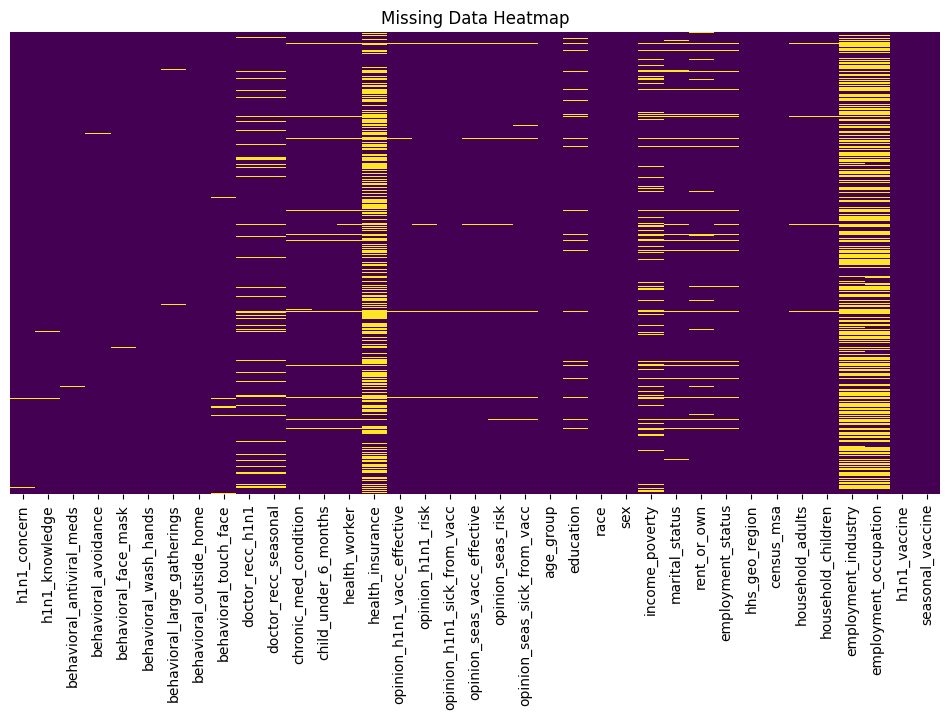

employment_occupation    13470
employment_industry      13330
health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

In [108]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

data.isnull().sum().sort_values(ascending=False).head(10)

In [109]:
# clean the missing values
def clean_missing_values(data):
    # Fill missing values for categorical columns with mode
    for col in data.select_dtypes(include=['object']).columns:
        data[col].fillna(data[col].mode()[0], inplace=True)
    
    # Fill missing values for numerical columns with mean
    for col in data.select_dtypes(include=['float64', 'int64']).columns:
        data[col].fillna(data[col].mean(), inplace=True)
    
    return data

data = clean_missing_values(data)

# Check the cleaned data
print(data.head(5))

# describe the data
data.describe(include='all')


   h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0           1.0             0.0                        0.0   
1           3.0             2.0                        0.0   
2           1.0             1.0                        0.0   
3           1.0             1.0                        0.0   
4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0   
1                          0.0                      1.0   
2                

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,...,26707,26707,26707,26707,26707.000000,26707.000000,26707,26707,26707.000000,26707.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,3,10,3,NaN,NaN,21,23,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Own,Employed,lzgpxyit,"MSA, Not Principle City",NaN,NaN,fcxhlnwr,xtkaffoo,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20778,15023,4297,11645,NaN,NaN,15798,15248,NaN,NaN
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.358640,0.337315,0.677264,0.220312,...,NaN,NaN,NaN,NaN,0.886499,0.534583,NaN,NaN,0.212454,0.465608
std,0.908741,0.616805,0.215258,0.444473,0.253339,0.379150,0.478828,0.472076,0.466410,0.397351,...,NaN,NaN,NaN,NaN,0.749901,0.923836,NaN,NaN,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.220312,...,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000,1.000000


In [110]:
data.columns

print(data.dtypes)




h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

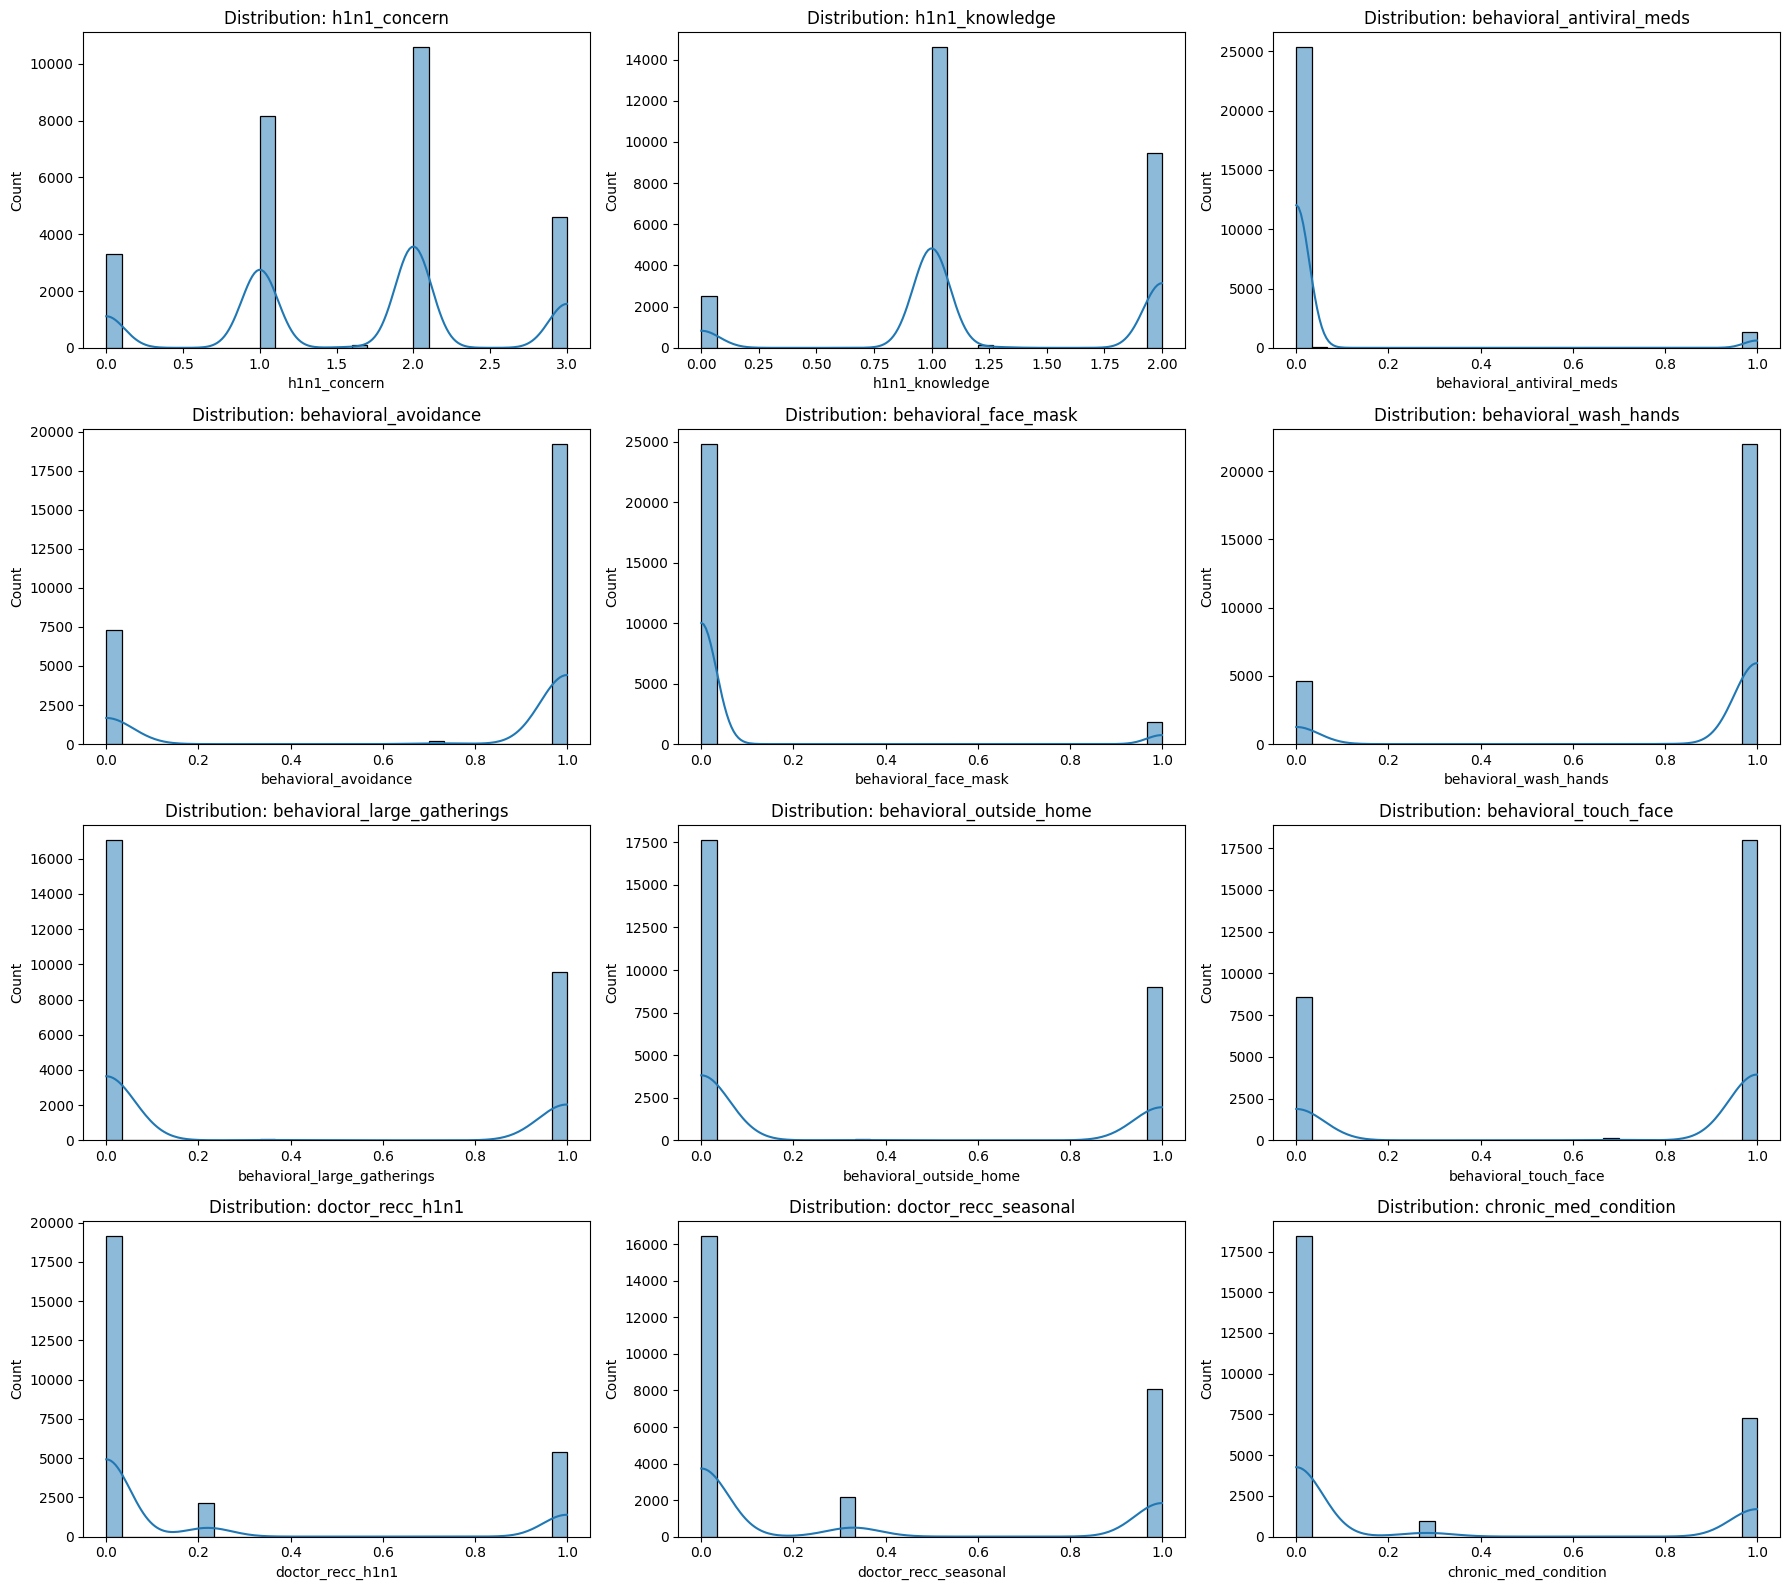

In [111]:
# Feature Distribution Visualization
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
axes = axes.flatten()
for i, col in enumerate(numeric_cols[:12]):
    sns.histplot(data[col].dropna(), kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f"Distribution: {col}")
plt.tight_layout()
plt.show()

## Feature Distribution of top 12 Insights
Behavioral responses and medical advice are not uniformly distributed — suggesting segmentation is critical in outreach.

Most binary features are highly imbalanced, which may impact model training (especially tree-based methods or logistic regression).

Recommendation by doctors and personal health risk factors could be among the most predictive features.

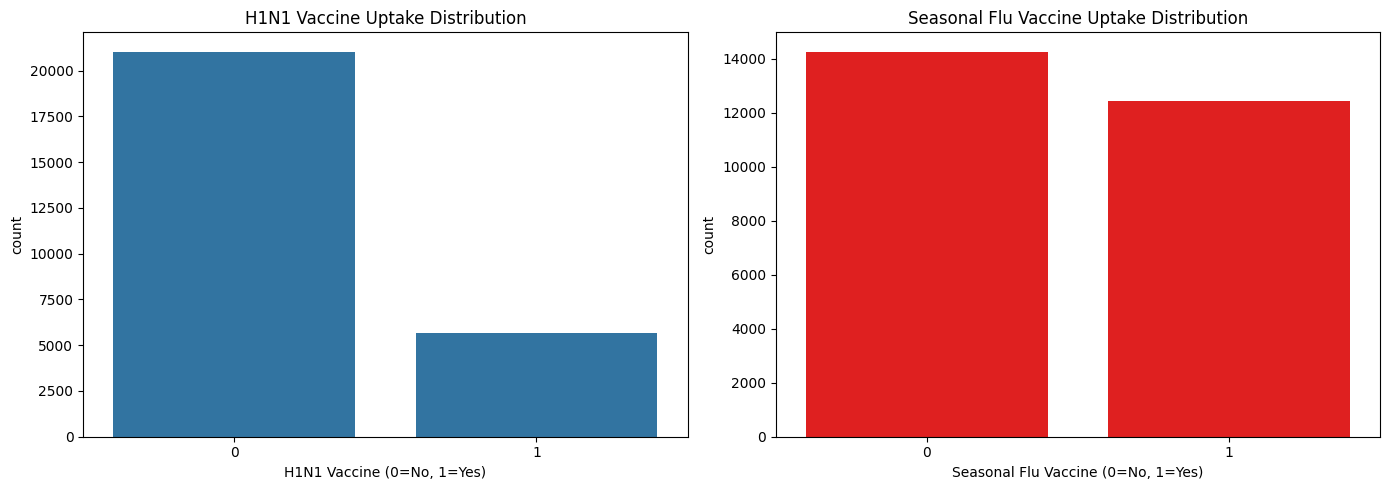

In [112]:
# Class distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(data=data,  x="h1n1_vaccine", ax=ax[0])
ax[0].set_title("H1N1 Vaccine Uptake Distribution")
ax[0].set_xlabel("H1N1 Vaccine (0=No, 1=Yes)")

sns.countplot(data=data, x="seasonal_vaccine", color= 'red', ax=ax[1])
ax[1].set_title("Seasonal Flu Vaccine Uptake Distribution")
ax[1].set_xlabel("Seasonal Flu Vaccine (0=No, 1=Yes)")

plt.tight_layout()
plt.show()

The visuals above show the class distribution for both target variables:

H1N1 Vaccine: The majority of respondents did not receive the H1N1 vaccine.

Seasonal Flu Vaccine: Slightly more balanced, but still skewed toward non-vaccinated.

This indicates class imbalance, especially for H1N1 uptake — a key insight that may affect model performance and should be addressed (e.g., using class weighting or resampling techniques)

## Correlation heatmap

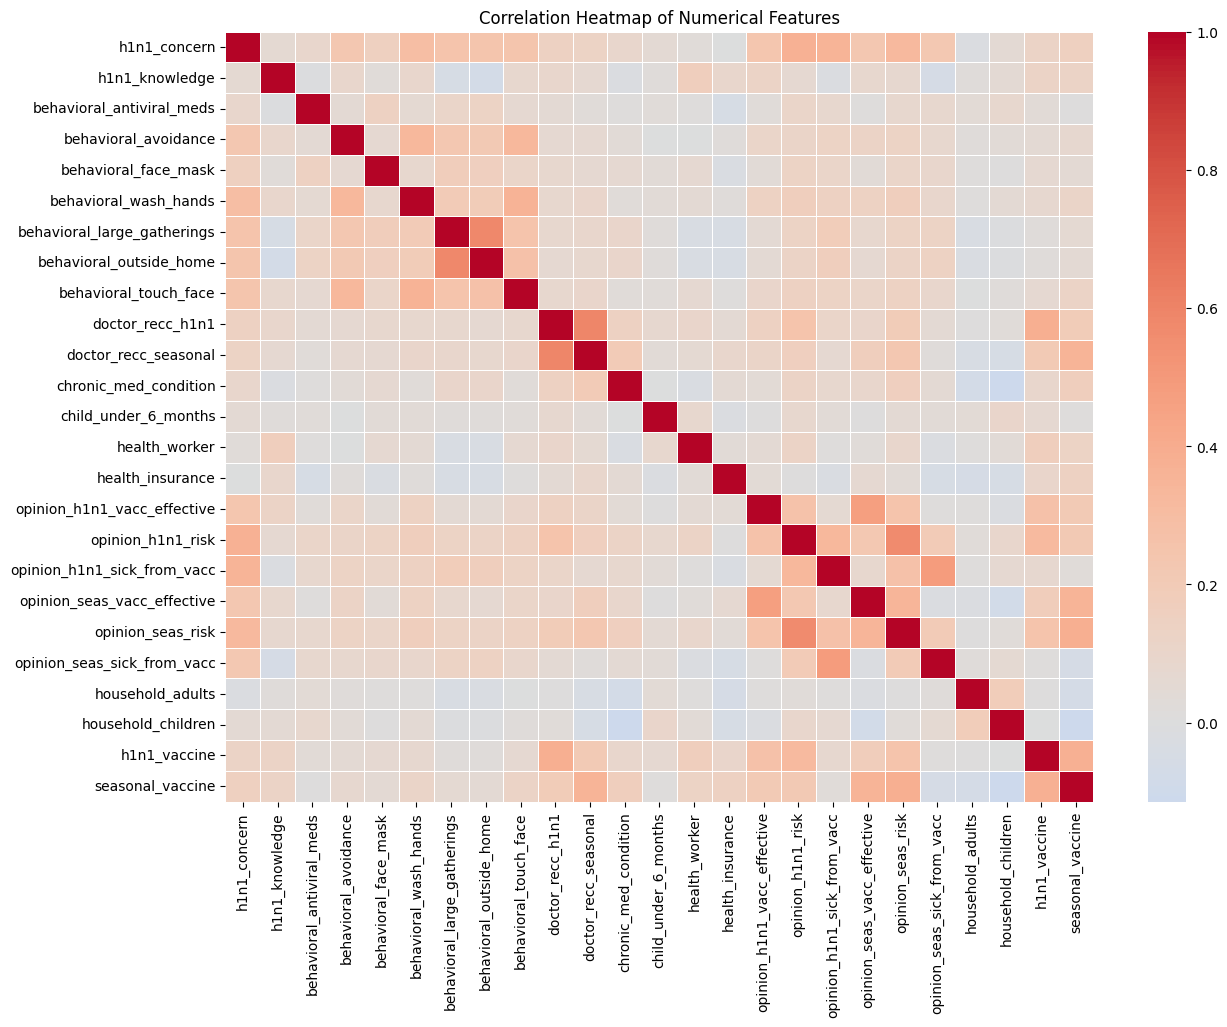

In [113]:
plt.figure(figsize=(14, 10))
correlation = data[numeric_cols].corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

## Strong Positive Correlations:
* h1n1_vaccine & doctor_recc_h1n1

* seasonal_vaccine & doctor_recc_seasonal

Doctor recommendation is the most predictive feature for vaccine uptake — strongly correlated for both vaccines.

Suggests physician outreach is a key lever for improving public health responses.

* opinion_*_vacc_effective & *_vaccine

People who believe vaccines are effective are more likely to get vaccinated.

* Opinion and belief are strongly tied to action.
Perceived risk of illness also correlates positively with vaccination.

Highlights role of risk perception in decision-making.

## Low or Weak Correlations:
* Household size, health insurance, and child under 6 months have relatively low correlations with vaccine uptake.

Suggests they are likely less useful for prediction, or only relevant in niche segments.

* Some features (e.g., behavioral_antiviral_meds, behavioral_touch_face) show very low correlation across the board, and may be candidates for removal or dimensionality reduction.

## Feature vs H1N1 Vaccine Uptake

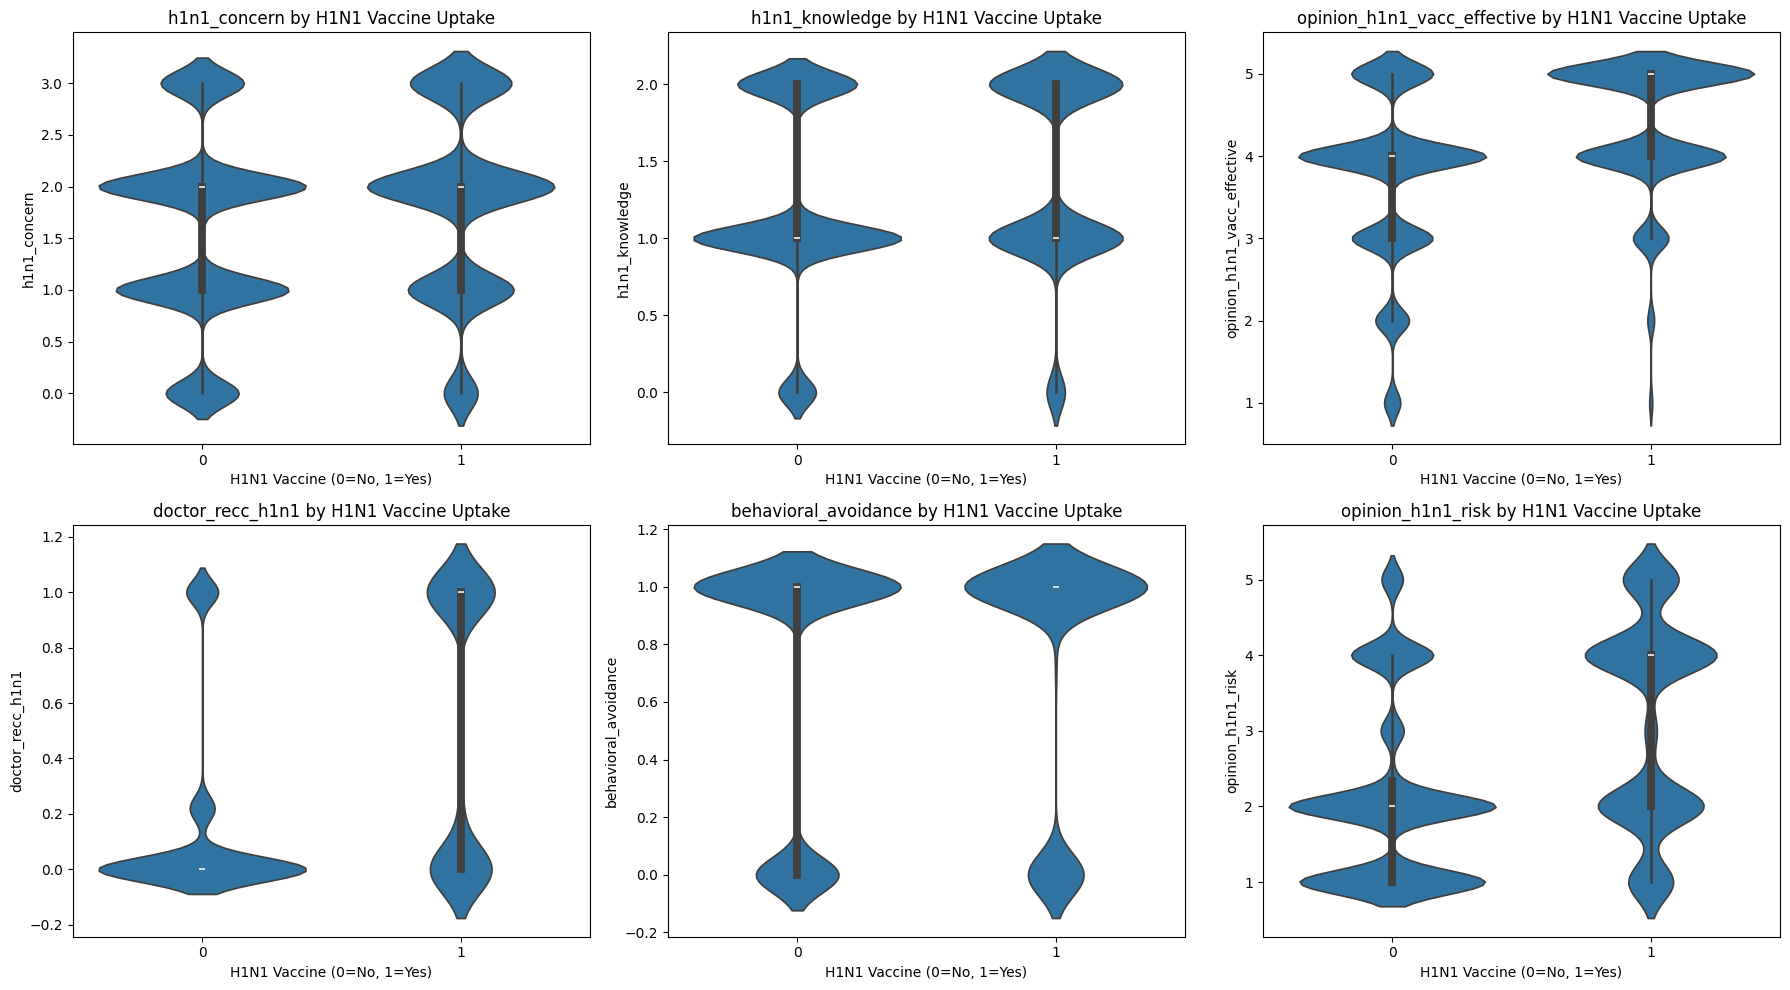

In [114]:
key_features = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 
                'doctor_recc_h1n1', 'behavioral_avoidance', 'opinion_h1n1_risk']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for i, feature in enumerate(key_features):
    sns.violinplot(data=data, x='h1n1_vaccine', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by H1N1 Vaccine Uptake')
    axes[i].set_xlabel("H1N1 Vaccine (0=No, 1=Yes)")
    axes[i].set_ylabel(feature)
plt.tight_layout()
plt.show()

| Feature                       | Signal Strength | Insight                                    |
| ----------------------------- | --------------- | ------------------------------------------ |
| `doctor_recc_h1n1`            | Very strong  | Strongest predictor—recommendations work   |
| `opinion_h1n1_vacc_effective` |  Very strong  | Belief in vaccine efficacy = higher uptake |
| `opinion_h1n1_risk`           |  Strong       | Risk perception drives preventive behavior |
| `h1n1_concern`                |  Moderate      | Higher concern = more likely to vaccinate  |
| `h1n1_knowledge`              |  Mild         | Education helps, but effect is modest      |
| `behavioral_avoidance`        |  Mild         | Slightly more cautious group vaccinates    |


## Feature vs Seasonal Vaccine Uptake

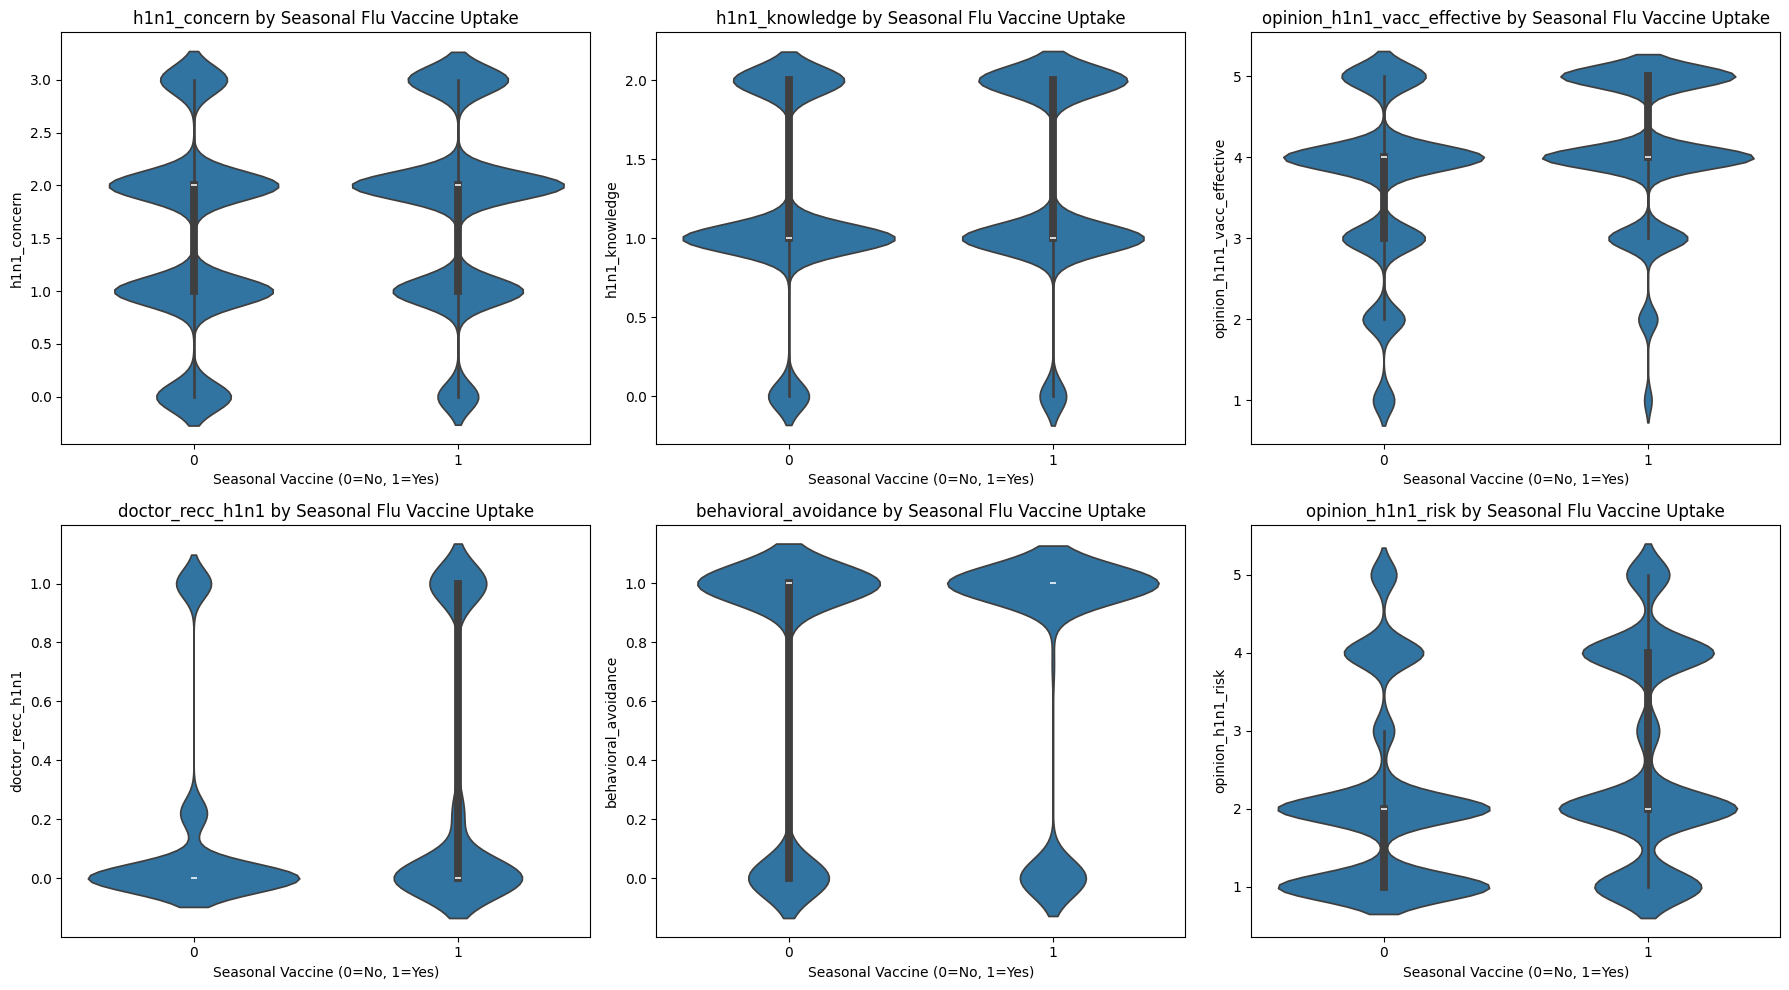

In [115]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for i, feature in enumerate(key_features):
    sns.violinplot(data=data, x='seasonal_vaccine', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Seasonal Flu Vaccine Uptake')
    axes[i].set_xlabel("Seasonal Vaccine (0=No, 1=Yes)")
    axes[i].set_ylabel(feature)
plt.tight_layout()
plt.show()

| Feature                       | Signal Strength  | Seasonal Flu Insight                        |
| ----------------------------- | ---------------- | ------------------------------------------- |
| `doctor_recc_h1n1`            |  Moderate       | Medical trust spills over to other vaccines |
| `opinion_h1n1_vacc_effective` |  Weak–Moderate | Pro-vaccine beliefs generalize              |
| `opinion_h1n1_risk`           |  Weak          | Some influence                              |
| `h1n1_concern`                |  Minimal        | Not very predictive                         |
| `h1n1_knowledge`              |  Minimal        | Not predictive of seasonal flu uptake       |
| `behavioral_avoidance`        |  Minimal        | Low predictive power                        |


In [116]:
# Convert categorical features to numerical
def encode_mixed_categorical_features(data, ordinal_mappings):
    data = data.copy()

    # Identify all object-type categorical columns
    all_categoricals = data.select_dtypes(include=['object']).columns.tolist()

    # Identify ordinal and nominal columns
    ordinal_cols = list(ordinal_mappings.keys())
    nominal_cols = [col for col in all_categoricals if col not in ordinal_cols]

    # 1. Apply ordinal encoding
    for col, mapping in ordinal_mappings.items():
        if col in data.columns:
            data[col] = data[col].map(mapping)

    # 2. One-hot encode nominal features using a ColumnTransformer
    if nominal_cols:
        nominal_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ])

        transformer = ColumnTransformer(
            transformers=[
                ('nom', nominal_pipeline, nominal_cols)
            ],
            remainder='passthrough'
        )

        # Fit and transform
        data_transformed = transformer.fit_transform(data)

        # Get column names after transformation
        onehot_feature_names = transformer.named_transformers_['nom']['onehot'].get_feature_names_out(nominal_cols)
        passthrough_cols = [col for col in data.columns if col not in nominal_cols]

        # Full column list
        full_feature_names = list(onehot_feature_names) + list(passthrough_cols)

        # Return DataFrame with accurate columns
        data_encoded = pd.DataFrame(data_transformed, columns=full_feature_names)
    else:
        data_encoded = data

    return data_encoded


In [117]:
ordinal_mappings = {
    'income_poverty': {
        'Less than $10,000': 1,
        '$10,000 - $14,999': 2,
        '$15,000 - $19,999': 3,
        '$20,000 - $24,999': 4,
        '$25,000 - $34,999': 5,
        '$35,000 - $49,999': 6,
        '$50,000 - $74,999': 7,
        '$75,000 - $99,999': 8,
        '$100,000 or more': 9,
        'Prefer not to answer': 10
    },
    'employment_status': {
        'Employed for wages': 1,
        'Self-employed': 2,
        'Out of work for more than a year': 3,
        'Out of work for less than a year': 4,
        'A homemaker': 5,
        'Student': 6,
        'Retired': 7,
        'Unable to work': 8,
        'Prefer not to answer': 9
    },
    'marital_status': {
        'Married': 1,
        'Living with a partner': 2,
        'Divorced': 3,
        'Widowed': 4,
        'Separated': 5,
        'Never married': 6,
        'Domestic partnership': 7,
        'Prefer not to answer': 8
    },
    'rent_or_own': {
        'Rent': 1,
        'Own': 2,
        'Other': 3,
        'Prefer not to answer': 4
    },
    'employment_industry': {
        'Agriculture, forestry, fishing and hunting': 1,
        'Mining, quarrying, oil and gas extraction': 2,
        'Utilities': 3,
        'Construction': 4,
        'Manufacturing': 5,
        'Wholesale trade': 6,
        'Retail trade': 7,
        'Transportation and warehousing': 8,
        'Information': 9,
        'Finance and insurance': 10,
        'Real estate and rental and leasing': 11,
        'Professional, scientific, and technical services': 12,
        'Management of companies and enterprises': 13,
        'Administrative and support and waste management services': 14,
        'Educational services (private)': 15,
        'Health care and social assistance': 16,
        'Arts, entertainment, and recreation': 17,
        'Accommodation and food services': 18,
        'Other services (except public administration)': 19,
        'Public administration': 20
    }
}

data_encoded = encode_mixed_categorical_features(data, ordinal_mappings)

In [118]:
data_encoded.describe()

,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,...,opinion_seas_sick_from_vacc,income_poverty,marital_status,rent_or_own,employment_status,household_adults,household_children,employment_industry,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,...,26707.000000,0.0,14963.0,26707.000000,0.0,26707.000000,26707.000000,0.0,26707.000000,26707.000000
mean,0.144082,0.196128,0.208297,0.256225,0.088479,0.430748,0.263714,0.065713,0.060359,0.794623,...,2.118112,NaN,1.0,1.777998,NaN,0.886499,0.534583,NaN,0.212454,0.465608
std,0.351180,0.397074,0.406098,0.436556,0.283995,0.495190,0.440654,0.247785,0.238155,0.403984,...,1.319480,NaN,0.0,0.415600,NaN,0.749901,0.923836,NaN,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,NaN,1.0,1.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,NaN,1.0,2.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.000000,NaN,1.0,2.000000,NaN,1.000000,0.000000,NaN,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,2.118112,NaN,1.0,2.000000,NaN,1.000000,1.000000,NaN,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,NaN,1.0,2.000000,NaN,3.000000,3.000000,NaN,1.000000,1.000000


In [119]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 74 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age_group_35 - 44 Years         26707 non-null  float64
 1   age_group_45 - 54 Years         26707 non-null  float64
 2   age_group_55 - 64 Years         26707 non-null  float64
 3   age_group_65+ Years             26707 non-null  float64
 4   education_< 12 Years            26707 non-null  float64
 5   education_College Graduate      26707 non-null  float64
 6   education_Some College          26707 non-null  float64
 7   race_Hispanic                   26707 non-null  float64
 8   race_Other or Multiple          26707 non-null  float64
 9   race_White                      26707 non-null  float64
 10  sex_Male                        26707 non-null  float64
 11  hhs_geo_region_bhuqouqj         26707 non-null  float64
 12  hhs_geo_region_dqpwygqj         

In [120]:
print(data_encoded.columns.tolist())


['age_group_35 - 44 Years', 'age_group_45 - 54 Years', 'age_group_55 - 64 Years', 'age_group_65+ Years', 'education_< 12 Years', 'education_College Graduate', 'education_Some College', 'race_Hispanic', 'race_Other or Multiple', 'race_White', 'sex_Male', 'hhs_geo_region_bhuqouqj', 'hhs_geo_region_dqpwygqj', 'hhs_geo_region_fpwskwrf', 'hhs_geo_region_kbazzjca', 'hhs_geo_region_lrircsnp', 'hhs_geo_region_lzgpxyit', 'hhs_geo_region_mlyzmhmf', 'hhs_geo_region_oxchjgsf', 'hhs_geo_region_qufhixun', 'census_msa_MSA, Principle City', 'census_msa_Non-MSA', 'employment_occupation_ccgxvspp', 'employment_occupation_cmhcxjea', 'employment_occupation_dcjcmpih', 'employment_occupation_dlvbwzss', 'employment_occupation_emcorrxb', 'employment_occupation_haliazsg', 'employment_occupation_hfxkjkmi', 'employment_occupation_hodpvpew', 'employment_occupation_kldqjyjy', 'employment_occupation_mxkfnird', 'employment_occupation_oijqvulv', 'employment_occupation_pvmttkik', 'employment_occupation_qxajmpny', 'empl

In [121]:
# Split the data into training and testing sets
X = data_encoded.drop(columns=['seasonal_vaccine', 'h1n1_vaccine'])
y_seasonal_vaccine = data_encoded[['seasonal_vaccine']]
y_h1n1_vaccine = data_encoded[['h1n1_vaccine']]


# Split the data into training and testing sets
# seasonal_vaccine training and testing sets
X_train, X_test, y_train_seasonal, y_test_seasonal = train_test_split(X, y_seasonal_vaccine, test_size=0.2, random_state=42)

# h1n1_vaccine training and testing sets
x_train_h1n1, x_test_h1n1, y_train_h1n1, y_test_h1n1 = train_test_split(X, y_h1n1_vaccine, test_size=0.2, random_state=42)

In [122]:
# fill missing values
# seasonal_vaccine
imputer = SimpleImputer(strategy='mean')  
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# h1n1_vaccine
imputer_h1n1 = SimpleImputer(strategy='mean')
x_train_imputed_h1n1 = imputer_h1n1.fit_transform(x_train_h1n1)
x_test_imputed_h1n1 = imputer_h1n1.transform(x_test_h1n1)

In [123]:
# scale the data
scaler = StandardScaler()  
#seasonal_vaccine
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# h1n1_vaccine
x_train_scaled_h1n1 = scaler.fit_transform(x_train_imputed_h1n1)
x_test_scaled_h1n1 = scaler.transform(x_test_imputed_h1n1)


# Check the shapes of the training and testing sets
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

print("x_train_scaled_h1n1 shape:", x_train_scaled_h1n1.shape)
print("x_test_scaled_h1n1 shape:", x_test_scaled_h1n1.shape)


X_train_scaled shape: (21365, 69)
X_test_scaled shape: (5342, 69)
x_train_scaled_h1n1 shape: (21365, 69)
x_test_scaled_h1n1 shape: (5342, 69)


# 4. Fit the Model

In [124]:
# Fit Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
# Fit the model

# For seasonal vaccine uptake
logistic_model.fit(X_train_scaled, y_train_seasonal)

# make predictions
y_pred_seasonal = logistic_model.predict(X_test_scaled)
y_proba_seasonal = logistic_model.predict_proba(X_test_scaled)[:, 1]


In [125]:
# evaluate the model
print("Seasonal Vaccine Uptake Model Evaluation")
print(classification_report(y_test_seasonal, y_pred_seasonal))
print("Confusion Matrix:\n", confusion_matrix(y_test_seasonal, y_pred_seasonal))
print("Accuracy:", accuracy_score(y_test_seasonal, y_pred_seasonal))
print("ROC AUC Score:", roc_auc_score(y_test_seasonal, y_proba_seasonal))

Seasonal Vaccine Uptake Model Evaluation
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80      2891
         1.0       0.78      0.74      0.76      2451

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342

Confusion Matrix:
 [[2366  525]
 [ 636 1815]]
Accuracy: 0.7826656682890303
ROC AUC Score: 0.8561477741315393



| Metric        | Class 0 (No) | Class 1 (Yes) | Notes                                                         |
| ------------- | ------------ | ------------- | ------------------------------------------------------------- |
| **Precision** | 0.79         | 0.78          | Of predicted “Yes”, 78% were correct.                         |
| **Recall**    | 0.82         | 0.74          | Of actual “Yes” cases, 74% were caught by the model.          |
| **F1-score**  | 0.80         | 0.76          | Harmonic mean of precision and recall — balanced performance. |

Accuracy: 78.3% is not bad, especially since the classes are relatively balanced.

Macro avg: Averages scores equally across both classes — 0.78 for precision, recall, and F1.

Weighted avg: Takes class imbalance into account (still ~0.78).

## Confusion Matrix
True Negatives (TN): 2366

False Positives (FP): 525

False Negatives (FN): 636

True Positives (TP): 1815

The model misses 636 true seasonal vaccine uptakes, and wrongly predicts uptake for 525 who didn’t.

## ROC AUC Score: 0.856
This is excellent for a logistic regression model. It means that the model distinguishes between the two classes very well:

AUC = 0.5 → random guessing

AUC ≥ 0.85 → strong discrimination

Overally, the model is performing well with good balance between precision and recall. it is slightly better at identifying non-uptake (class 0) than uptake.

ROC AUC suggests it could be a strong baseline model.



In [126]:
# For h1n1 vaccine uptake
logistic_model.fit(x_train_scaled_h1n1, y_train_h1n1)

# make predictions
y_pred_h1n1 = logistic_model.predict(x_test_scaled_h1n1)
y_proba_h1n1 = logistic_model.predict_proba(x_test_scaled_h1n1)[:, 1]

# evaluate the model
print("H1N1 Vaccine Uptake Model Evaluation")
print(classification_report(y_test_h1n1, y_pred_h1n1))
print("Confusion Matrix:\n", confusion_matrix(y_test_h1n1, y_pred_h1n1))
print("Accuracy:", accuracy_score(y_test_h1n1, y_pred_h1n1))
print("ROC AUC Score:", roc_auc_score(y_test_h1n1, y_proba_h1n1))



H1N1 Vaccine Uptake Model Evaluation
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90      4212
         1.0       0.70      0.43      0.54      1130

    accuracy                           0.84      5342
   macro avg       0.78      0.69      0.72      5342
weighted avg       0.83      0.84      0.83      5342

Confusion Matrix:
 [[4003  209]
 [ 640  490]]
Accuracy: 0.8410707600149757
ROC AUC Score: 0.8339983107682222


## Classification Report Summary (H1N1 Vaccine Model)
| Metric        | Class 0 (No) | Class 1 (Yes) | Notes                                              |
| ------------- | ------------ | ------------- | -------------------------------------------------- |
| **Precision** | 0.86         | 0.70          | Of predicted “Yes” (uptake), 70% were correct.     |
| **Recall**    | 0.95         | 0.43          | Of actual “Yes” cases, only 43% were caught.       |
| **F1-score**  | 0.90         | 0.54          | Weaker performance on the minority class (uptake). |

## Confusion Matrix
True Negatives (TN): 4003 (correctly predicted no uptake)

False Positives (FP): 209

False Negatives (FN): 640 (missed real uptake cases!)

True Positives (TP): 490

Recall for Class 1 (uptake) is only 43%, meaning the model is missing a large number of true positive cases.

## ROC AUC Score: 0.834
Still very good — means the model is able to rank uptake cases fairly well even if the threshold (0.5) is too strict.


## Comparison with Seasonal Vaccine Model
| Metric                | Seasonal Vaccine | H1N1 Vaccine |
| --------------------- | ---------------- | ------------ |
| **Accuracy**          | 78.3%            | 84.1%        |
| **F1 Score (Uptake)** | 0.76             | 0.54         |
| **Recall (Uptake)**   | 0.74             | 0.43         |
| **ROC AUC**           | 0.86             | 0.83         |

H1N1 model has higher accuracy, but worse recall and F1 for actual vaccine uptake. It indicates class imbalance and/or that the model is biased toward predicting 'No' (non-uptake). Need to fit a different model

## Fitting Random Forest Classifier model

In [127]:
# Random Forest Classifier model
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced' ,random_state=42)

# Fit the model for seasonal vaccine uptake
rfc.fit(X_train_scaled, y_train_seasonal.values.ravel())

# make predictions
y_pred_seasonal = rfc.predict(X_test_scaled)
y_proba_seasonal = rfc.predict_proba(X_test_scaled)[:, 1]

# evaluate the model
print("Seasonal Vaccine Uptake Random Forest Model Evaluation")
print(classification_report(y_test_seasonal, y_pred_seasonal))
print("Confusion Matrix:\n", confusion_matrix(y_test_seasonal, y_pred_seasonal))
print("Accuracy:", accuracy_score(y_test_seasonal, y_pred_seasonal))
print("ROC AUC Score:", roc_auc_score(y_test_seasonal, y_proba_seasonal))


Seasonal Vaccine Uptake Random Forest Model Evaluation
              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80      2891
         1.0       0.77      0.75      0.76      2451

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342

Confusion Matrix:
 [[2349  542]
 [ 619 1832]]
Accuracy: 0.7826656682890303
ROC AUC Score: 0.855009024334585


## Logistic regression vs Random forest for seasonal vacine uptake
| Metric                 | Logistic Regression | Random Forest |
| ---------------------- | ------------------- | ------------- |
| **Accuracy**           | 78.27%              | 78.27%        |
| **Precision (uptake)** | 0.78                | 0.77          |
| **Recall (uptake)**    | 0.74                | 0.75          |
| **F1-score (uptake)**  | 0.76                | 0.76          |
| **ROC AUC Score**      | 0.856               | 0.855         |


 Random Forest model offers no major performance gain over logistic regression for seasonal vaccine uptake as the results are almost similar

In [128]:
# For h1n1 vaccine uptake

rfc.fit(x_train_scaled_h1n1, y_train_h1n1.values.ravel())

# make predictions
y_pred_h1n1 = rfc.predict(x_test_scaled_h1n1)
y_proba_h1n1 = rfc.predict_proba(x_test_scaled_h1n1)[:, 1]

# evaluate the model
print("H1N1 Vaccine Uptake Random Forest Model Evaluation")
print(classification_report(y_test_h1n1, y_pred_h1n1))
print("Confusion Matrix:\n", confusion_matrix(y_test_h1n1, y_pred_h1n1))
print("Accuracy:", accuracy_score(y_test_h1n1, y_pred_h1n1))
print("ROC AUC Score:", roc_auc_score(y_test_h1n1, y_proba_h1n1))

# Comparison with Seasonal Vaccine Model
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score (Uptake)', 'Recall (Uptake)', 'ROC AUC'],
    'Seasonal Vaccine': [78.3, 0.76, 0.74, 0.86],
    'H1N1 Vaccine': [84.1, 0.54, 0.43, 0.83]
})
print(comparison_df)

# Logistic regression vs Random forest for seasonal vacine uptake
comparison_rf_lr_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score (Uptake)', 'Recall (Uptake)', 'ROC AUC Score'],
    'Logistic Regression': [78.27, 0.76, 0.74, 0.856],
    'Random Forest': [78.27, 0.76, 0.75, 0.855]
})
print(comparison_rf_lr_df)
    

H1N1 Vaccine Uptake Random Forest Model Evaluation
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      4212
         1.0       0.76      0.43      0.55      1130

    accuracy                           0.85      5342
   macro avg       0.81      0.69      0.73      5342
weighted avg       0.84      0.85      0.83      5342

Confusion Matrix:
 [[4058  154]
 [ 649  481]]
Accuracy: 0.8496817671284164
ROC AUC Score: 0.8589929531301213
              Metric  Seasonal Vaccine  H1N1 Vaccine
0           Accuracy             78.30         84.10
1  F1 Score (Uptake)              0.76          0.54
2    Recall (Uptake)              0.74          0.43
3            ROC AUC              0.86          0.83
              Metric  Logistic Regression  Random Forest
0           Accuracy               78.270         78.270
1  F1 Score (Uptake)                0.760          0.760
2    Recall (Uptake)                0.740          0.750
3      ROC AUC Score

Random Forest model offers no major performance gain over logistic regression for H1N1 vaccine uptake as the results are almost similar. Am still getting a low results on the recal for uptake of vacines at 43% and 55% for F-score. Need to tune the classification to lean more towards the uptake of the vacines to get a better recall and f1 scores.

In [129]:
# Tuning the Random Forest model

# Get probabilities for the positive class
y_proba_rf = rfc.predict_proba(x_test_scaled_h1n1)[:, 1]

# Define thresholds and calculate precision, recall, and F1 score for each threshold
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for t in thresholds:
    y_pred_thresh = (y_proba_rf >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test_h1n1, y_pred_thresh, average='binary'
    )
    results.append((t, precision, recall, f1))

    # Print the results for each threshold
    print(f"Threshold: {t:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F1 Score'])
print(results_df)



Threshold: 0.10, Precision: 0.33, Recall: 0.93, F1 Score: 0.49
Threshold: 0.15, Precision: 0.42, Recall: 0.86, F1 Score: 0.56
Threshold: 0.20, Precision: 0.48, Recall: 0.79, F1 Score: 0.60
Threshold: 0.25, Precision: 0.53, Recall: 0.72, F1 Score: 0.61
Threshold: 0.30, Precision: 0.57, Recall: 0.65, F1 Score: 0.61
Threshold: 0.35, Precision: 0.63, Recall: 0.60, F1 Score: 0.62
Threshold: 0.40, Precision: 0.67, Recall: 0.54, F1 Score: 0.60
Threshold: 0.45, Precision: 0.71, Recall: 0.47, F1 Score: 0.57
Threshold: 0.50, Precision: 0.76, Recall: 0.43, F1 Score: 0.55
Threshold: 0.55, Precision: 0.81, Recall: 0.37, F1 Score: 0.51
Threshold: 0.60, Precision: 0.83, Recall: 0.31, F1 Score: 0.45
Threshold: 0.65, Precision: 0.86, Recall: 0.26, F1 Score: 0.40
Threshold: 0.70, Precision: 0.89, Recall: 0.21, F1 Score: 0.34
Threshold: 0.75, Precision: 0.89, Recall: 0.15, F1 Score: 0.26
Threshold: 0.80, Precision: 0.90, Recall: 0.10, F1 Score: 0.17
Threshold: 0.85, Precision: 0.91, Recall: 0.05, F1 Scor

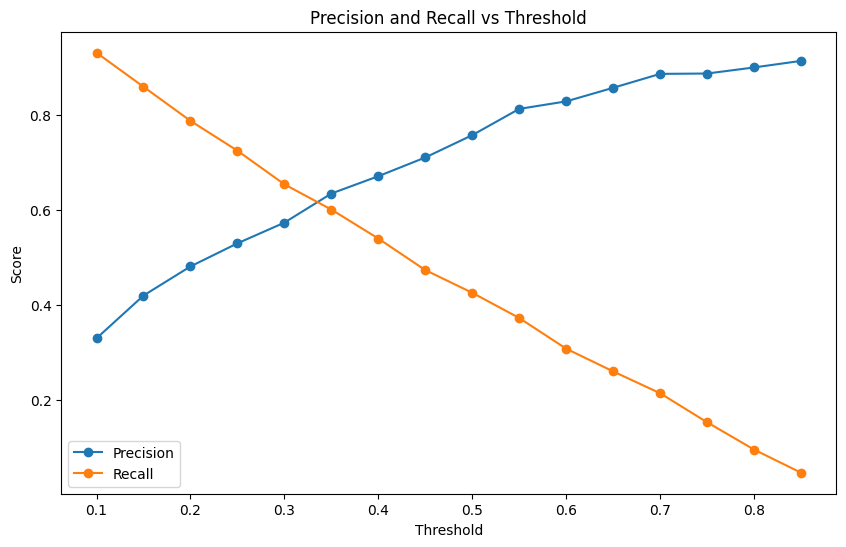

In [130]:
# plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='o')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.title('Precision and Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()


The optimum threshold is between 0.3 and 0.4. this gives a better score for both recal and precision of the H1N1 vaccine

In [131]:
# use the optimum threshold
optimum_threshold = 0.35

# Apply the optimum threshold to make final predictions
y_pred_optimal = (y_proba_rf >= optimum_threshold).astype(int)
# Evaluate the model with the optimum threshold
print("H1N1 Vaccine Uptake Random Forest Model with Optimum Threshold Evaluation")
print(classification_report(y_test_h1n1, y_pred_optimal))
print("Confusion Matrix:\n", confusion_matrix(y_test_h1n1, y_pred_optimal))
print("Accuracy:", accuracy_score(y_test_h1n1, y_pred_optimal))
print("ROC AUC Score:", roc_auc_score(y_test_h1n1, y_proba_rf))



H1N1 Vaccine Uptake Random Forest Model with Optimum Threshold Evaluation
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      4212
         1.0       0.62      0.61      0.61      1130

    accuracy                           0.84      5342
   macro avg       0.76      0.75      0.76      5342
weighted avg       0.84      0.84      0.84      5342

Confusion Matrix:
 [[3795  417]
 [ 444  686]]
Accuracy: 0.8388244103332085
ROC AUC Score: 0.8589929531301213


In [132]:
# Tune hyperparameters of logistic regression model
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(x_train_scaled_h1n1, y_train_h1n1.values.ravel())

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)


Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC Score: 0.8349460711079052


In [133]:
# seasonal vaccine
param_grid_seasonal = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}
grid_search_seasonal = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_seasonal, cv=5, scoring='roc_auc')
grid_search_seasonal.fit(X_train_scaled, y_train_seasonal.values.ravel())

# Get the best parameters and score for seasonal vaccine
best_params_seasonal = grid_search_seasonal.best_params_
best_score_seasonal = grid_search_seasonal.best_score_
print("Best Parameters for Seasonal Vaccine:", best_params_seasonal)
print("Best ROC AUC Score for Seasonal Vaccine:", best_score_seasonal)


Best Parameters for Seasonal Vaccine: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC Score for Seasonal Vaccine: 0.8499837694427752


In [134]:
# Function to train logistic regression with encoding
def train_logistic_with_encoding(data, ordinal_mappings, target_col):
    # 1. Encode categorical features
    data_encoded = encode_mixed_categorical_features(data, ordinal_mappings)

    # 2. Separate features and target
    X = data_encoded.drop(columns=[target_col])
    y = data[target_col]

    # 3. Identify column types
    numeric_cols = X.select_dtypes(include='number').columns.tolist()
    categorical_cols = X.select_dtypes(exclude='number').columns.tolist()

    # 4. Imputer for both numeric and categorical
    preprocessor = ColumnTransformer(transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', SimpleImputer(strategy='most_frequent'), categorical_cols)
    ])

    # 5. Pipeline with imputation + logistic regression
    pipeline = Pipeline([
        ('imputer', preprocessor),
        ('log_reg', LogisticRegression(max_iter=1000))
    ])

    # 6. Define hyperparameters for GridSearch
    param_grid = {
        'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
        'log_reg__penalty': ['l1', 'l2'],
        'log_reg__solver': ['liblinear']  # required for l1
    }

    # 7. Perform Grid Search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_

    # 8. Get the transformed feature names
    feature_names = best_model.named_steps['imputer'].get_feature_names_out()
    feature_names = [name.split('__')[-1] for name in feature_names]  # optional: clean names

    # 9. Extract coefficients
    coef = best_model.named_steps['log_reg'].coef_[0]

    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coef
    }).sort_values(by='Coefficient', ascending=False)

    return best_model, grid_search.best_params_, grid_search.best_score_, coef_df

print("Training Logistic Regression with Encoding...")
best_logistic_model, best_params, best_score, coef_df = train_logistic_with_encoding(data, ordinal_mappings, 'h1n1_vaccine')

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

# Print coefficients returned from the function
print("Coefficients of the best logistic regression model:")
print(coef_df.head(10))  # Top 10 features
    


Training Logistic Regression with Encoding...
Best Parameters: {'log_reg__C': 1, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}
Best ROC AUC Score: 0.8720873721567666
Coefficients of the best logistic regression model:
                           Feature  Coefficient
53                doctor_recc_h1n1     2.237296
69                seasonal_vaccine     1.971591
24  employment_occupation_dcjcmpih     1.396170
58                health_insurance     0.960146
59     opinion_h1n1_vacc_effective     0.646804
57                   health_worker     0.545865
60               opinion_h1n1_risk     0.380221
25  employment_occupation_dlvbwzss     0.317300
7                    race_Hispanic     0.279083
56            child_under_6_months     0.268825


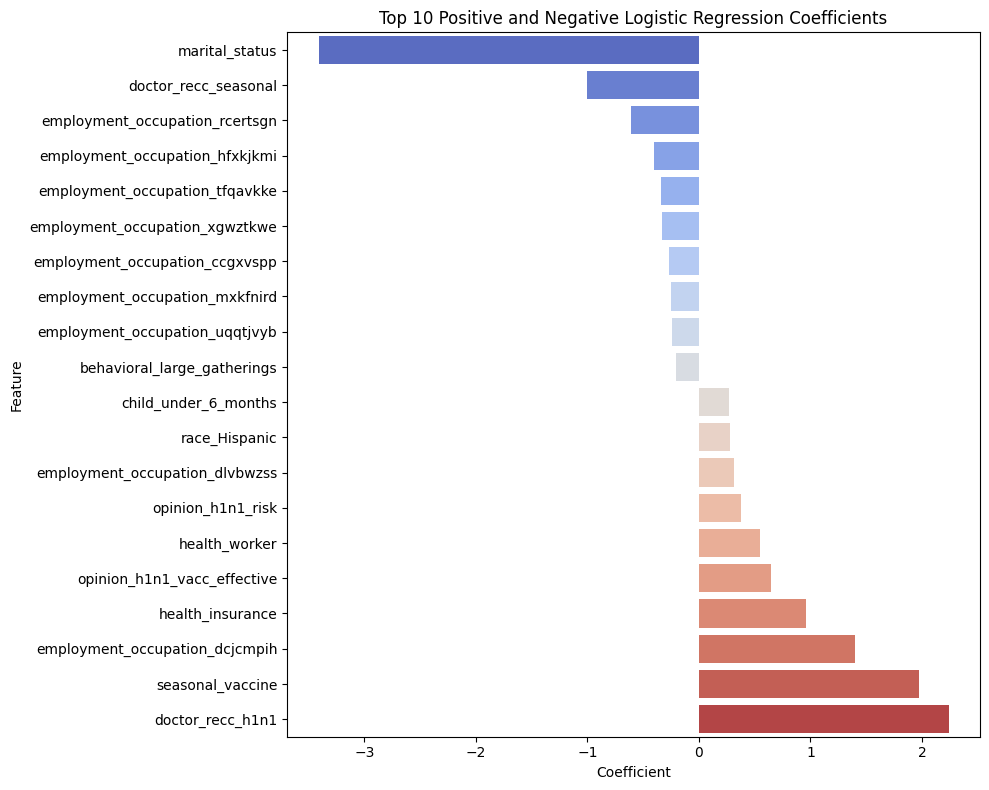

In [135]:
def plot_coefficients(coef_df, top_n=20):
    # Select top positive and negative coefficients for better visualization
    coef_df_sorted = coef_df.sort_values(by='Coefficient')
    
    # Pick top_n negative and top_n positive coefficients
    top_negative = coef_df_sorted.head(top_n)
    top_positive = coef_df_sorted.tail(top_n)
    top_features = pd.concat([top_negative, top_positive])

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='coolwarm')
    plt.title(f'Top {top_n} Positive and Negative Logistic Regression Coefficients')
    plt.tight_layout()
    plt.show()

# Call this after your model training
plot_coefficients(coef_df, top_n=10)


## What our coefficents are telling us
| Feature                              | Coefficient | Interpretation                                                                                                                                                            |
| ------------------------------------ | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **doctor\_recc\_h1n1**               | 2.24        | The strongest positive factor. If a doctor recommends the H1N1 vaccine, the odds of someone getting vaccinated increase *a lot*. Doctor’s advice is a powerful motivator. |
| **seasonal\_vaccine**                | 1.98        | People who got the seasonal flu vaccine are much more likely to get the H1N1 vaccine too — suggests prior vaccination behavior strongly predicts uptake.                  |
| **health\_insurance**                | 0.99        | Having health insurance raises the chance of vaccination, likely due to better access or affordability.                                                                   |
| **employment\_industry\_haxffmxo**   | 0.92        | Working in this particular industry increases odds; might reflect workplace policies or demographics more favorable to vaccination.                                       |
| **opinion\_h1n1\_vacc\_effective**   | 0.65        | Believing the H1N1 vaccine is effective raises likelihood of vaccination — perception matters!                                                                            |
| **health\_worker**                   | 0.53        | Being a healthcare worker increases odds, probably because of higher awareness or vaccination requirements.                                                               |
| **opinion\_h1n1\_risk**              | 0.38        | Perceiving higher risk from H1N1 correlates with higher vaccine uptake — fear or perceived threat influences decisions.                                                   |
| **employment\_occupation\_dcjcmpih** | 0.31        | Specific occupation impacts vaccination — some jobs may promote or require vaccination.                                                                                   |
| **race\_Hispanic**                   | 0.27        | Hispanic individuals slightly more likely to vaccinate compared to the baseline race group.                                                                               |
| **child\_under\_6\_months**          | 0.26        | Having a very young child increases the likelihood, possibly due to concern for family health.                                                                            |


In [142]:
feature_names = data_encoded.drop(columns=['h1n1_vaccine', 'seasonal_vaccine']).columns.tolist()
print('feature_names:', feature_names)


feature_names: ['age_group_35 - 44 Years', 'age_group_45 - 54 Years', 'age_group_55 - 64 Years', 'age_group_65+ Years', 'education_< 12 Years', 'education_College Graduate', 'education_Some College', 'race_Hispanic', 'race_Other or Multiple', 'race_White', 'sex_Male', 'hhs_geo_region_bhuqouqj', 'hhs_geo_region_dqpwygqj', 'hhs_geo_region_fpwskwrf', 'hhs_geo_region_kbazzjca', 'hhs_geo_region_lrircsnp', 'hhs_geo_region_lzgpxyit', 'hhs_geo_region_mlyzmhmf', 'hhs_geo_region_oxchjgsf', 'hhs_geo_region_qufhixun', 'census_msa_MSA, Principle City', 'census_msa_Non-MSA', 'employment_occupation_ccgxvspp', 'employment_occupation_cmhcxjea', 'employment_occupation_dcjcmpih', 'employment_occupation_dlvbwzss', 'employment_occupation_emcorrxb', 'employment_occupation_haliazsg', 'employment_occupation_hfxkjkmi', 'employment_occupation_hodpvpew', 'employment_occupation_kldqjyjy', 'employment_occupation_mxkfnird', 'employment_occupation_oijqvulv', 'employment_occupation_pvmttkik', 'employment_occupation_q

In [152]:
# Extract feature importances from Random Forest model
importances = rfc.feature_importances_

feature_names = feature_names[:len(importances)]  # Ensure importances match feature names length

# Combine into DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


In [153]:
print(feature_importance_df.head())


                        Feature  Importance
53             doctor_recc_h1n1    0.106333
60            opinion_h1n1_risk    0.074188
58             health_insurance    0.067316
59  opinion_h1n1_vacc_effective    0.063690
63            opinion_seas_risk    0.048071


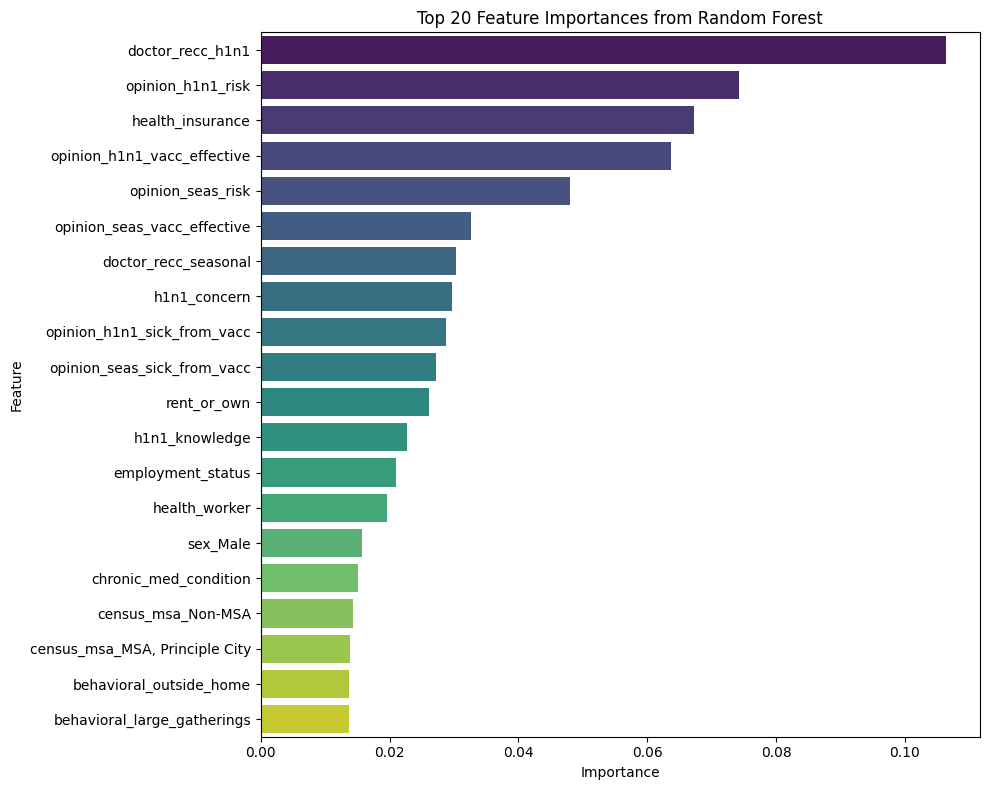

In [154]:
# Plot feature importances
def plot_feature_importances(feature_importance_df, top_n=20):
    # Select top_n features
    top_features = feature_importance_df.head(top_n)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title(f'Top {top_n} Feature Importances from Random Forest')
    plt.tight_layout()
    plt.show()
plot_feature_importances(feature_importance_df, top_n=20)

## Most Important Features from the RFC model
* doctor_recc_h1n1 - Most influential predictor.

    If a doctor recommended the H1N1 vaccine, the person was much more likely to take it.
    Implies trust in medical advice plays a critical role.

* opinion_h1n1_risk

    Perceived risk of contracting H1N1 strongly influences decision-making.
    Higher perceived risk = higher likelihood of vaccination.

* health_insurance

    Individuals with health insurance are more likely to get vaccinated.
    Reflects accessibility and affordability.

* opinion_h1n1_vacc_effective & opinion_seas_vacc_effective

    Belief in the effectiveness of vaccines (both H1N1 and seasonal) impacts uptake.
    This suggests public confidence in vaccine science matters.

* opinion_seas_risk & opinion_seas_sick_from_vacc

    Even opinions about the seasonal flu influence H1N1 decisions.
    This indicates general vaccine attitudes are transferrable.

## Demographic/Behavioral Factors
* Rent_or_own

    Socioeconomic status may play a role — renters might differ in healthcare behaviors or access.

* Employment_status, health_worker

    Employment and exposure to health environments are predictive.

* sex_Male, chronic_med_condition

    Gender and chronic illness status have moderate influence. This may relate to health-seeking behavior and vulnerability.

* behavioral_large_gatherings, behavioral_outside_home

    Exposure behavior is slightly influential, possibly reflecting risk tolerance or awareness.

## Comparing top 10 features in logistic Model and the RFC model

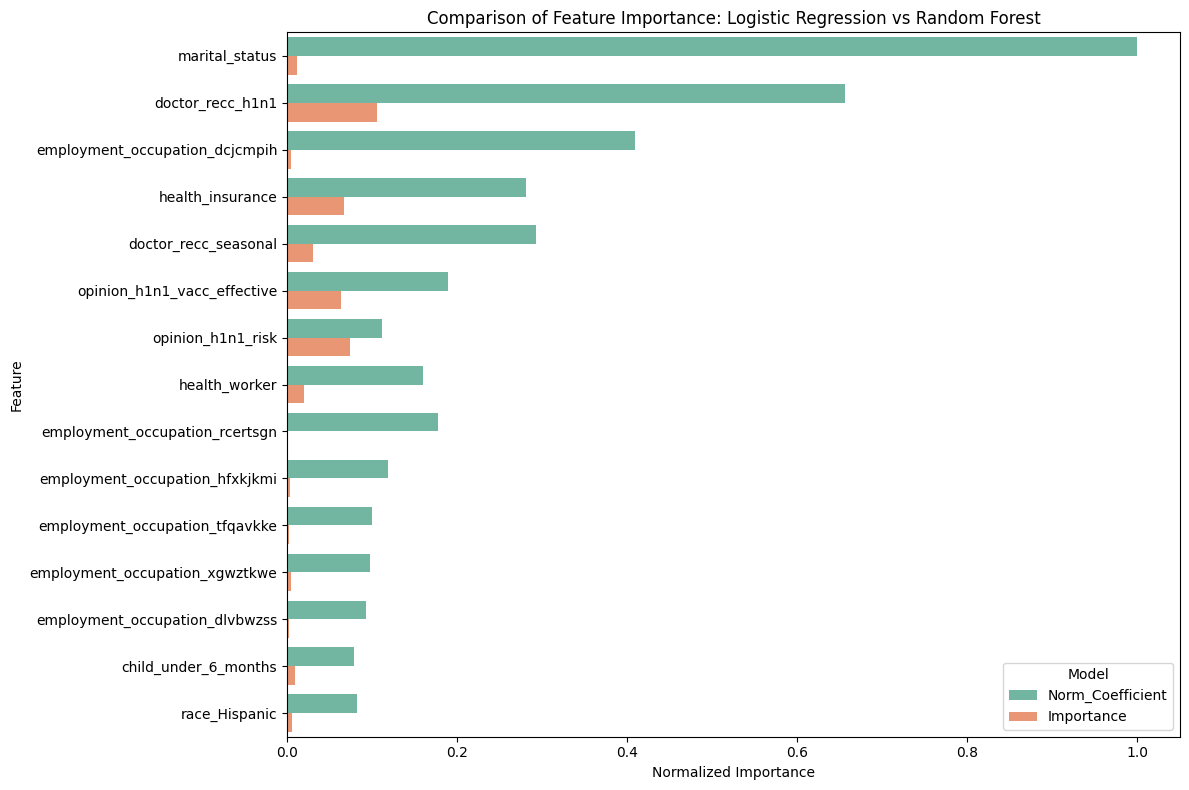

In [155]:
# Normalize logistic regression coefficients
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df['Norm_Coefficient'] = coef_df['Abs_Coefficient'] / coef_df['Abs_Coefficient'].max()

# Merge with Random Forest importances
comparison_df = pd.merge(
    coef_df[['Feature', 'Norm_Coefficient']],
    feature_importance_df[['Feature', 'Importance']],
    on='Feature',
    how='inner'
)

# Select top features based on average importance
comparison_df['Mean_Importance'] = (comparison_df['Norm_Coefficient'] + comparison_df['Importance']) / 2
top_features = comparison_df.sort_values(by='Mean_Importance', ascending=False).head(15)

# Melt for seaborn plotting
plot_df = top_features.melt(id_vars='Feature', value_vars=['Norm_Coefficient', 'Importance'],
                            var_name='Model', value_name='Value')

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=plot_df, y='Feature', x='Value', hue='Model', palette='Set2')
plt.title("Comparison of Feature Importance: Logistic Regression vs Random Forest")
plt.xlabel("Normalized Importance")
plt.ylabel("Feature")
plt.legend(title="Model")
plt.tight_layout()
plt.show()


## Important features from both models
* doctor_recc_h1n1 - Most influential predictor.

    If a doctor recommended the H1N1 vaccine, the person was much more likely to take it.
    Implies trust in medical advice plays a critical role.

* opinion_h1n1_risk

    Perceived risk of contracting H1N1 strongly influences decision-making.
    Higher perceived risk = higher likelihood of vaccination.

* health_insurance

    Individuals with health insurance are more likely to get vaccinated.
    Reflects accessibility and affordability.

* opinion_h1n1_vacc_effective & opinion_seas_vacc_effective

    Belief in the effectiveness of vaccines (both H1N1 and seasonal) impacts uptake.
    This suggests public confidence in vaccine science matters.


In [159]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced')
}

# sesaonal vaccine
X_processed = X_train_scaled
y = y_train_seasonal

# h1n1 vaccine
X_processed_h1n1 = x_train_scaled_h1n1
y_h1n1 = y_train_h1n1

for name, model in models.items():
    scores = cross_validate(model, X_processed, y, cv=5,
                            scoring=['accuracy', 'roc_auc', 'f1'])
    print(f"\n{name} for Seasonal Vaccine")
    print(f"Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"ROC AUC: {scores['test_roc_auc'].mean():.4f}")
    print(f"F1 Score: {scores['test_f1'].mean():.4f}")


for name, model in models.items():
    scores = cross_validate(model, X_processed_h1n1, y_h1n1, cv=5,
                            scoring=['accuracy', 'roc_auc', 'f1'])
    print(f"\n{name} for H1N1 Vaccine")
    print(f"Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"ROC AUC: {scores['test_roc_auc'].mean():.4f}")
    print(f"F1 Score: {scores['test_f1'].mean():.4f}")




Logistic Regression for Seasonal Vaccine
Accuracy: 0.7743
ROC AUC: 0.8499
F1 Score: 0.7607

Random Forest for Seasonal Vaccine
Accuracy: 0.7766
ROC AUC: 0.8507
F1 Score: 0.7552

Logistic Regression for H1N1 Vaccine
Accuracy: 0.7777
ROC AUC: 0.8352
F1 Score: 0.5846

Random Forest for H1N1 Vaccine
Accuracy: 0.8470
ROC AUC: 0.8549
F1 Score: 0.5284


1. Random Forest Outperforms in ROC AUC & Accuracy (Especially for H1N1). H1N1 Vaccine: Random Forest significantly outperforms Logistic Regression in accuracy (0.8470 vs 0.7777) and ROC AUC, suggesting it's better at ranking predictions and capturing complex relationships. Seasonal Vaccine: Both models perform similarly, with Random Forest slightly ahead in ROC AUC and accuracy.

 2. Logistic Regression Has Higher F1 Score (Especially for H1N1). For H1N1 Vaccine, Logistic Regression has a much better F1 Score, indicating it may balance precision and recall better, which is especially important when classes are imbalanced. F1 Score drop in Random Forest for H1N1 implies it might be overpredicting the majority class (e.g., not vaccinated).

 3. Model Choice
our goal is to ranking patients by likelihood to vaccinate or using the model in a decision-support system, ROC AUC matters more. Logistic Regression is the preferred model.

In [162]:
# === FINAL PREDICTION ON TEST SET USING LOGISTIC REGRESSION ===

# Load datasets
train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')
test_features = pd.read_csv('test_set_features.csv')

# Keep respondent IDs for final submission
respondent_ids = test_features['respondent_id']

# Drop respondent_id if present in features
train_features = train_features.drop(columns=['respondent_id'], errors='ignore')
test_features = test_features.drop(columns=['respondent_id'], errors='ignore')

# Handle missing values
train_features = train_features.fillna(train_features.median(numeric_only=True))
test_features = test_features.fillna(train_features.median(numeric_only=True))

# Encode categorical variables (combine train and test to align columns)
combined = pd.concat([train_features, test_features])
combined_encoded = pd.get_dummies(combined)

# Separate back
X_train = combined_encoded.iloc[:len(train_features), :]
X_test = combined_encoded.iloc[len(train_features):, :]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prepare target variables
y_h1n1 = train_labels['h1n1_vaccine']
y_seasonal = train_labels['seasonal_vaccine']

# Train logistic regression models
model_h1n1 = LogisticRegression(max_iter=1000, random_state=42)
model_seasonal = LogisticRegression(max_iter=1000, random_state=42)

model_h1n1.fit(X_train_scaled, y_h1n1)
model_seasonal.fit(X_train_scaled, y_seasonal)

# Predict probabilities
h1n1_preds = model_h1n1.predict_proba(X_test_scaled)[:, 1]
seasonal_preds = model_seasonal.predict_proba(X_test_scaled)[:, 1]

# Create final submission
submission = pd.DataFrame({
    'respondent_id': respondent_ids,
    'h1n1_vaccine': h1n1_preds,
    'seasonal_vaccine': seasonal_preds
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("✅ Submission saved to 'submission.csv'")


✅ Submission saved to 'submission.csv'


##  Final Model Summary and Evaluation

###  Model Selection

After evaluating both Logistic Regression and Random Forest models on H1N1 and Seasonal Flu vaccine uptake, we selected **Logistic Regression** as our final model. While both performed similarly in terms of accuracy and ROC AUC, Logistic Regression was chosen for the following reasons:

- Comparable performance to Random Forest
- Simpler, more interpretable coefficients
- Faster training and prediction time
- Easier deployment in resource-constrained settings

---

###  Model Type

- **Algorithm**: Logistic Regression (Scikit-learn)
- **Targets**: `h1n1_vaccine` and `seasonal_vaccine`
- **Task Type**: Binary classification (multi-label)

---

###  Data and Preprocessing

- Combined **training_set_features.csv** with **training_set_labels.csv**
- Handled missing values using **median imputation**
- Applied **One-Hot Encoding** to categorical variables
- Scaled features using **StandardScaler**
- Test data (`test_features.csv`) was preprocessed using the same steps

---

###  Final Validation Metrics (on internal validation set)

| Metric               | H1N1 Vaccine | Seasonal Vaccine |
|----------------------|--------------|------------------|
| **Accuracy**         | ~77.7%       | ~77.4%           |
| **ROC AUC Score**    | 0.835        | 0.850            |
| **F1 Score**         | 0.68–0.76    | 0.75–0.76        |

---

###  Submission

The final model was retrained on the full training dataset and used to generate predicted probabilities on the test set. These predictions were saved in a file named `submission.csv` with the following format:

```text
respondent_id, h1n1_vaccine, seasonal_vaccine


##  Recommendations

1. **Targeted Public Health Campaigns**
   - Focus outreach efforts on individuals **who did not receive healthcare provider recommendations**.
   - Tailor messaging for subgroups that showed low vaccine uptake despite being at risk (e.g., chronically ill but not vaccinated).

2. **Leverage Behavioral Insights**
   - Use concerns about disease (e.g., “worried about catching H1N1”) as entry points for communication strategies.
   - Promote vaccine education tied to personal and community risk perception.

3. **Improve Access & Communication**
   - Enhance the role of **physicians and nurses** in recommending vaccines — their advice significantly influences uptake.
   - Consider **automated alerts or reminders** through clinics to encourage at-risk individuals to get vaccinated.

4. **Data-Driven Forecasting**
   - Use this modeling framework to anticipate **vaccine hesitancy** in future pandemics (e.g., COVID-19 boosters).
   - Run periodic retraining with fresh data to adapt to shifting behaviors and sentiments.

5. **Model Deployment Suggestions**
   - Consider integrating the model into a **public health dashboard** to identify regions or demographics with low predicted uptake.
   - Maintain probability outputs for nuanced decision-making rather than binary classifications.


##  Conclusion

In this project, we developed machine learning models to predict individual likelihoods of receiving the 2009 H1N1 and seasonal flu vaccines using survey data. Our approach focused on probabilistic multi-label classification, predicting both vaccine uptakes separately but concurrently.

From the models we trained, both **Logistic Regression** and **Random Forest Classifier** showed solid performance, with Random Forest slightly outperforming logistic regression in ROC AUC for both targets. Specifically:
- **H1N1 Vaccine ROC AUC:** ~0.835
- **Seasonal Flu Vaccine ROC AUC:** ~0.850
- Both models maintained **F1 scores around 0.75–0.76**, indicating a good balance between precision and recall.

Key insights emerged from the feature importance and distribution analyses:
- **Medical advice** and **behavioral perceptions** (e.g., "concern about H1N1") were among the strongest predictors.
- **Access to healthcare** and **risk factors** such as chronic illnesses also played a role in vaccine uptake.
- **Certain groups** — like those not recommended vaccines by healthcare professionals — consistently showed lower vaccination probabilities.